# Algorithm
Markerless Pose Detection -> Joint Locations -> Kinematics Computing -> Gait Cycle Extraction

In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
import cv2
import math
from tqdm.notebook import tqdm

Helper fuctions

In [23]:
joint_names = np.array(['pelv', 'lhip', 'rhip', 'spi1', 'lkne', 'rkne', 'spi2', 'lank',
                        'rank', 'spi3', 'ltoe', 'rtoe', 'neck', 'lcla', 'rcla', 'head',
                        'lsho', 'rsho', 'lelb', 'relb', 'lwri', 'rwri', 'lhan', 'rhan'])


def get_correct_content(frames_len, contents):
    # content can be missing or duplicated
    contents_arr = np.array(contents)
    idx_list = np.array([int(i['image_id'].split('.')[0]) for i in contents_arr])

    output_data = []
    for i in range(frames_len):
        if len(contents_arr[idx_list==i])==0:
            d = {}
            d['poses2d'] = np.zeros((24,2))*np.nan
            d['poses3d'] = np.zeros((24,3))*np.nan
            
        elif len(contents_arr[idx_list==i])==1:
            d = contents_arr[idx_list==i][0]
            d['poses2d'] = np.asarray(d['keypoints']).reshape(29,3)[:24,:2] # https://github.com/Jeff-sjtu/HybrIK/issues/52 -> 29 to 24 kps
            d['poses3d'] = np.asarray(d['pred_xyz_jts'])        
        else:
            sub_data = contents_arr[idx_list==i]
            max_scored_data = sub_data[0]
            for this_data in sub_data[1:]:
                if this_data['score'] > max_scored_data['score']:
                    max_scored_data = this_data

            d = max_scored_data

            d['poses2d'] = np.asarray(d['keypoints']).reshape(29,3)[:24,:2] # https://github.com/Jeff-sjtu/HybrIK/issues/52 -> 29 to 24 kps
            d['poses3d'] = np.asarray(d['pred_xyz_jts'])
        output_data.append(d)

    if len(output_data)==frames_len:
        return output_data
    else:
        print('Error')
        return []


def get_frames(video_filepath):
    # Initialize the VideoCapture object to read from a video stored in the disk.
    video = cv2.VideoCapture(video_filepath)

    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    frames = []

    for i in range(total_frames):
        # Read a frame.
        ok, frame = video.read()

        # Check if frame is not read properly.
        if not ok:
            # Break the loop.
            break

        frames.append(frame)
    
    return frames


def get_predictions_content(prediction_filepath):
    with open(prediction_filepath, 'r') as j:
        contents = json.loads(j.read())

    return contents


def get_predictions_and_frames_alphapose(file_name):
    file_name_split = file_name.split('_')
    if len(file_name_split) == 4: # NM
        dataset_loc = file_name_split[1]
    else: # KOA
        dataset_loc = file_name_split[1]+'/'+file_name_split[1]+'_'+file_name_split[3]

    video_loc = '../dataset/KOA-PD-NM/'
    video_filepath = os.path.join(video_loc, dataset_loc, file_name.split('_results')[0]+'.MOV')
    frames = get_frames(video_filepath)

    prediction_loc = 'alphapose_preds'
    prediction_filepath = os.path.join(prediction_loc, dataset_loc, file_name+'.json')
    contents = get_predictions_content(prediction_filepath)

    predictions = get_correct_content(len(frames), contents)

    return predictions, frames


def format_predictions(predictions):
    # convert input to dict
    n_frames = len(predictions)
    n_joints = len(predictions[0]['poses3d'])
    joints_loc_list2d = np.zeros([n_frames, n_joints,2])
    joints_loc_list3d = np.zeros([n_frames, n_joints,3])

    for i, frame_data_dict in enumerate(predictions):
        for j, joint_data in enumerate(frame_data_dict['poses2d']):
                joints_loc_list2d[i][j][:] = joint_data[:]
        for j, joint_data in enumerate(frame_data_dict['poses3d']):
                joints_loc_list3d[i][j][:] = joint_data[:]

    predictions_formatted = {}
    predictions_formatted['poses2d'] = joints_loc_list2d
    predictions_formatted['poses3d'] = joints_loc_list3d
    predictions_formatted['joint_names'] = joint_names

    return predictions_formatted


def visualize_frame(image, poses2d, edges):
    fig = plt.figure(figsize=(10, 5))
    plt.imshow(image)

    for pose2d in poses2d:
        for i_start, i_end in edges:
            plt.plot(*zip(pose2d[i_start], pose2d[i_end]), marker='o', markersize=2)

        plt.scatter(*pose2d.T, s=2)

    plt.axis('off')
    fig.tight_layout()


def visualize_frame_seq(frame_id, frames, predictions, edges):
    fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 35))
 
    for i in range(5):
        image = frames[frame_id-2+i]
        poses2d = [predictions['poses2d'][frame_id-2+i]]
        ax[i].imshow(image)

        for pose2d in poses2d:
            for i_start, i_end in edges:
                ax[i].plot(*zip(pose2d[i_start], pose2d[i_end]), marker='o', markersize=2)

            ax[i].scatter(*pose2d.T, s=2)

        ax[i].axis('off')
    fig.tight_layout()


def calculate_knee_angle(joints_loc):
    """
    Calculate the knee joint angle given hip, knee, and ankle positions.
    
    Parameters:
        joints_loc (list or array): [[x, y], [x, y],[x, y]] coordinates of the hip, knee and ankle joints.
    
    Returns:
        float: Knee joint angle in degrees.
    """
    # Convert inputs to numpy arrays
    hip = np.array(joints_loc[0])
    knee = np.array(joints_loc[1])
    ankle = np.array(joints_loc[2])

    # Vectors
    proximal_vector = hip - knee  # From knee to hip
    distal_vector = ankle - knee  # From knee to ankle

    # Normalize the vectors
    proximal_norm = np.linalg.norm(proximal_vector)
    distal_norm = np.linalg.norm(distal_vector)

    # Prevent division by zero
    if proximal_norm == 0 or distal_norm == 0:
        raise ValueError("Zero-length vector found! Check input joint positions.")

    # Calculate the cosine of the angle
    cos_theta = np.dot(proximal_vector, distal_vector) / (proximal_norm * distal_norm)

    # Clamp values to avoid numerical precision issues
    cos_theta = np.clip(cos_theta, -1.0, 1.0)

    # Angle in radians and convert to degrees
    angle_radians = math.acos(cos_theta)
    angle_degrees = math.degrees(angle_radians)

    # Adjust to get the flexion angle (smaller angle between vectors)
    knee_angle = 180 - angle_degrees

    return knee_angle


def get_chain_idx():
    joint_chain_dict = {}

    joint_names2idx = {j:i for i,j in enumerate(joint_names.tolist())}
    joint_chain = ['lhip', 'lkne', 'lank']
    joint_chain_idx = [joint_names2idx[j] for j in joint_chain]
    joint_edges_for_plot = [[joint_names2idx[joint_chain[i]], joint_names2idx[joint_chain[i+1]]] for i in range(2)]
    joint_chain_dict['lkne'] = {'joint_name': 'Left Knee',
                                'joint_chain':joint_chain, 
                                'chain_idx':joint_chain_idx, 
                                'edges_for_plot':joint_edges_for_plot}

    joint_chain = ['rhip', 'rkne', 'rank']
    joint_chain_idx = [joint_names2idx[j] for j in joint_chain]
    joint_edges_for_plot = [[joint_names2idx[joint_chain[i]], joint_names2idx[joint_chain[i+1]]] for i in range(2)]
    joint_chain_dict['rkne'] = {'joint_name': 'Right Knee',
                                'joint_chain':joint_chain,
                                'chain_idx':joint_chain_idx, 
                                'edges_for_plot':joint_edges_for_plot}        
    
    return joint_chain_dict

joint_chain_dict = get_chain_idx()
joint_chain_dict

{'lkne': {'joint_name': 'Left Knee',
  'joint_chain': ['lhip', 'lkne', 'lank'],
  'chain_idx': [1, 4, 7],
  'edges_for_plot': [[1, 4], [4, 7]]},
 'rkne': {'joint_name': 'Right Knee',
  'joint_chain': ['rhip', 'rkne', 'rank'],
  'chain_idx': [2, 5, 8],
  'edges_for_plot': [[2, 5], [5, 8]]}}

# Run an example case 

In [24]:
file_name = '001_NM_01_results' #'010_KOA_01_SV_results' #'004_NM_02_results' # 001_KOA_01_EL_results 018_NM_02_results

predictions, frames = get_predictions_and_frames_alphapose(file_name)
print(len(frames), len(predictions))

predictions_data = format_predictions(predictions)
print(predictions_data['poses2d'].shape, predictions_data['poses3d'].shape)

118 118
(118, 24, 2) (118, 24, 3)


An example for joint position detection using markerless joint detection for single video frame

9.317416871516173


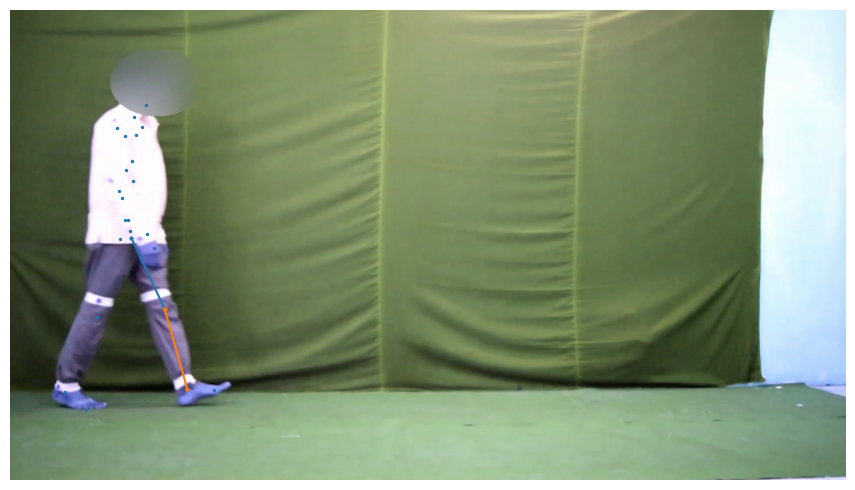

In [25]:
frame_id = 38
this_joint = 'lkne'

joint_chain = joint_chain_dict[this_joint]['chain_idx']
joint_edges_for_plot = joint_chain_dict[this_joint]['edges_for_plot']

frame_data = predictions_data['poses2d'][frame_id]
joints_loc = frame_data[joint_chain]

joint_angle_alphapose = calculate_knee_angle(joints_loc)

print(joint_angle_alphapose)
visualize_frame(frames[frame_id], [predictions_data['poses2d'][frame_id]], joint_edges_for_plot)

joint detection for 5 sequential video frame 

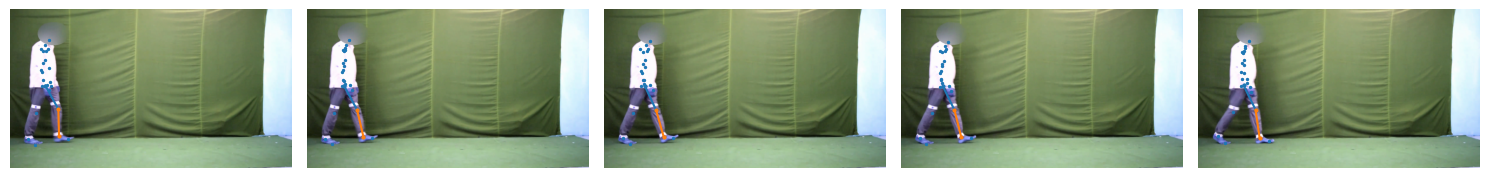

In [26]:
visualize_frame_seq(frame_id, frames, predictions_data, joint_edges_for_plot)

In [27]:
# Filter the joint locations 
from scipy.ndimage import uniform_filter1d

def filter_locations(joints_loc_list):
    joints_loc_list_filtered = np.zeros_like(joints_loc_list)

    for i in range(joints_loc_list.shape[1]):
        for j in range(joints_loc_list.shape[2]):
            sig = joints_loc_list[:,i,j]
            nans, x= np.isnan(sig), lambda z: z.nonzero()[0]
            sig[nans]= np.interp(x(nans), x(~nans), sig[~nans])
            sigl_filtered = uniform_filter1d(sig, size=5)

            joints_loc_list_filtered[:,i,j] = sigl_filtered

    return joints_loc_list_filtered

predictions_data['poses2d_filtered'] = filter_locations(predictions_data['poses2d'])
predictions_data['poses3d_filtered'] = filter_locations(predictions_data['poses3d'])

Calculate lower extremities joint angles from joint detections for all frames in video 

In [28]:
def calculate_knee_angle_in_gait(gait_array):
    all_joint_angles = {}
    for side in ['lkne', 'rkne']:
        joint_angles = []
        for frame_id in range(gait_array.shape[0]):
            if len(gait_array[frame_id])>0:
                frame_data = gait_array[frame_id][:,:2]
                joint_chain = joint_chain_dict[side]['chain_idx']            
                joints_loc = frame_data[joint_chain]
                joint_angle = calculate_knee_angle(joints_loc)
            else:
                joint_angle = np.nan    
            joint_angles.append(joint_angle)
        all_joint_angles[side] = joint_angles
    return all_joint_angles


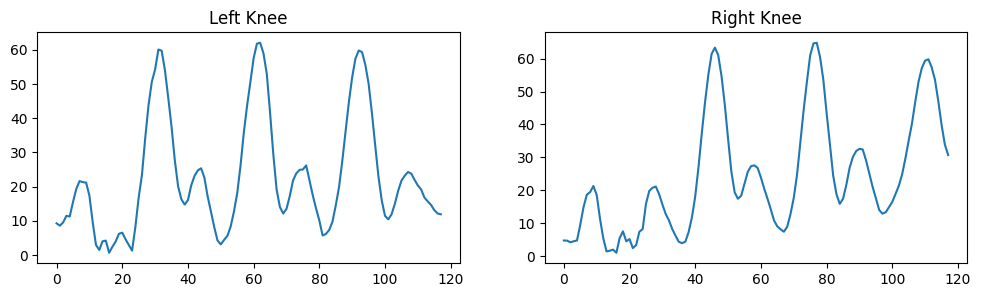

In [29]:
all_joint_angles = calculate_knee_angle_in_gait(predictions_data['poses2d_filtered'])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))
for i, side in enumerate(['lkne', 'rkne']):
    joint_angle_preds = all_joint_angles[side]
    ax[i].plot(joint_angle_preds)
    ax[i].set_title(joint_chain_dict[side]['joint_name'])

Determine gait cycles using the methods in this article
https://pubmed.ncbi.nlm.nih.gov/17723303/

In [30]:
from scipy.ndimage import uniform_filter1d
from scipy import signal
from scipy import stats

def get_Xdiffs(predictions, side):
    Xdiff_rank_pelv = predictions[:,joint_names==side+'ank',0] - predictions[:,joint_names=='pelv',0]
    Xdiff_rtoe_pelv = predictions[:,joint_names==side+'toe',0] - predictions[:,joint_names=='pelv',0]
    pelvis_loc = predictions[:,joint_names=='pelv',0]
    
    Xdiff_rank_pelv = Xdiff_rank_pelv.squeeze()
    Xdiff_rtoe_pelv = Xdiff_rtoe_pelv.squeeze()
    pelvis_loc = pelvis_loc.squeeze()

    discard_borders = int(len(pelvis_loc)*0.1) # 0.1 of beginning and end is discarded
    if np.diff(pelvis_loc[discard_borders:-1*discard_borders]).mean() < 0: # that means direction is from right to left
        Xdiff_rank_pelv = Xdiff_rank_pelv * -1
        Xdiff_rtoe_pelv = Xdiff_rtoe_pelv * -1

    return Xdiff_rank_pelv, Xdiff_rtoe_pelv

def get_peaks(sig):
    # handle nan's
    nans, x= np.isnan(sig), lambda z: z.nonzero()[0]
    sig[nans]= np.interp(x(nans), x(~nans), sig[~nans])

    # Compute the Z-scores of the signal
    z_scores = stats.zscore(sig)
    # Define a threshold for outliers (e.g., 3 standard deviations)
    threshold = 2
    outliers = np.where(np.abs(z_scores) > threshold)
    sig[outliers] = np.nan

    # handle nan's
    nans, x= np.isnan(sig), lambda z: z.nonzero()[0]
    sig[nans]= np.interp(x(nans), x(~nans), sig[~nans])
        
    sigl_filtered = uniform_filter1d(sig, size=5)
    sigl_filtered_norm = sigl_filtered/sigl_filtered.max()
    peaks, _ = signal.find_peaks(sigl_filtered_norm, height=0.5)
    return peaks

def get_gait_cycles(predictions, mode):
    frames_gc = {}
    if mode=='debug':
        Xdiff_rank_pelv_dict, frames_hs_dict, frames_hs_intervals_dict = {}, {}, {}

    for side in ['l','r']:
        Xdiff_rank_pelv, Xdiff_rtoe_pelv = get_Xdiffs(predictions, side)

        frames_hs = get_peaks(Xdiff_rank_pelv)
        if len(frames_hs)<2:
            frames_gc[side] = []
            continue
        
        frames_hs_intervals = np.diff(frames_hs)
        # eliminate noisy data, check length of hs data and remove outliers
        # should be improved
        Q1 = np.percentile(frames_hs_intervals, 25)
        Q3 = np.percentile(frames_hs_intervals, 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR        

        min_num_of_data = 10
        selected_idx = np.where((frames_hs_intervals >= lower_bound)&
                                (frames_hs_intervals <= upper_bound)&
                                (frames_hs_intervals >= min_num_of_data))[0]

        frames_gc[side] = []
        for idx in selected_idx:
            frames_gc[side].append([frames_hs[idx], frames_hs[idx+1]])
    
        if mode=='debug':
            Xdiff_rank_pelv_dict[side], frames_hs_dict[side], frames_hs_intervals_dict[side] = Xdiff_rank_pelv, frames_hs, frames_hs_intervals
            
    if mode=='debug':
        return frames_gc, Xdiff_rank_pelv_dict, frames_hs_dict, frames_hs_intervals_dict
    else:
        return frames_gc

frames_gc = get_gait_cycles(predictions_data['poses2d_filtered'], 'run')
frames_gc

{'l': [[38, 69], [69, 101]], 'r': [[54, 84]]}

Plot right knee angles from determined gait cycles

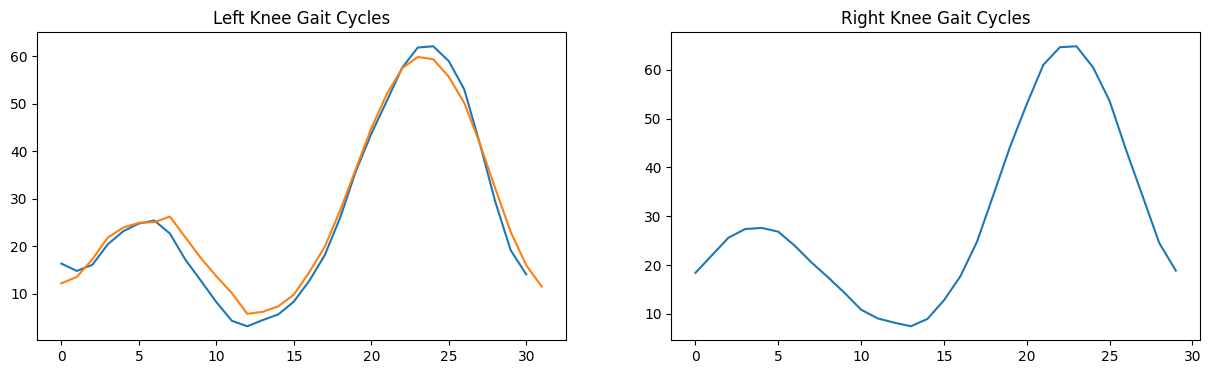

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

for i,i_1 in frames_gc['l']:
    ax[0].plot(all_joint_angles['lkne'][i:i_1])
ax[0].set_title('Left Knee Gait Cycles')

for i,i_1 in frames_gc['r']:
    ax[1].plot(all_joint_angles['rkne'][i:i_1])
ax[1].set_title('Right Knee Gait Cycles')
plt.show()

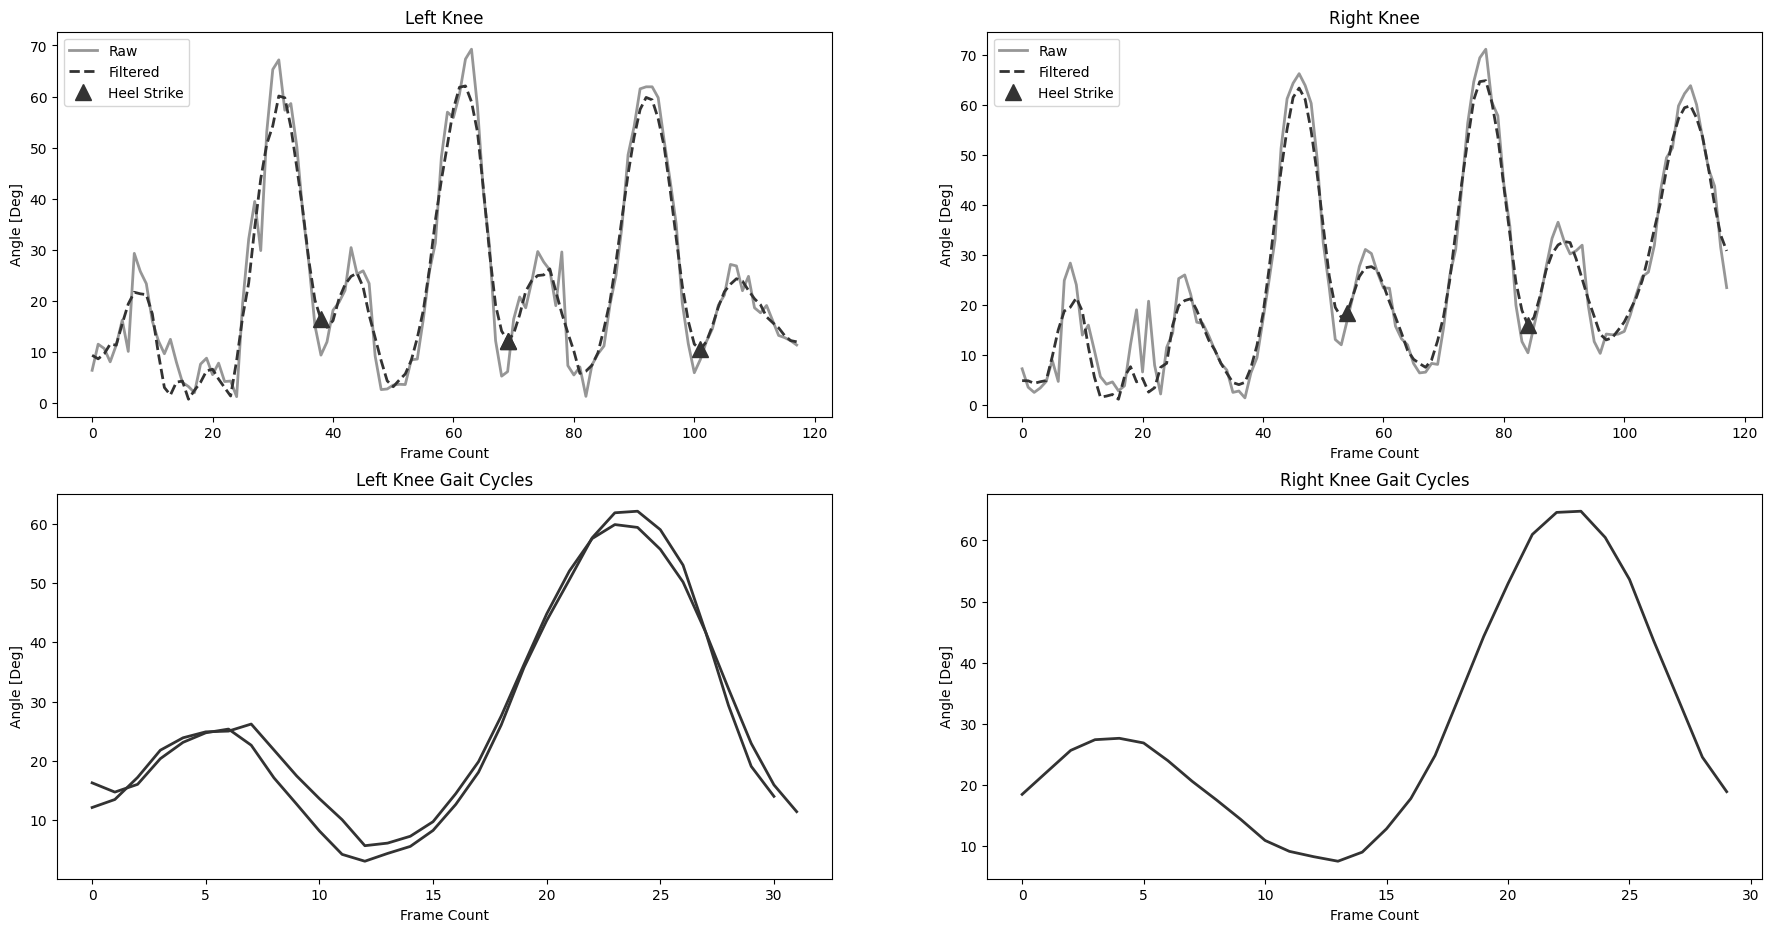

In [78]:
all_joint_angles = calculate_knee_angle_in_gait(predictions_data['poses2d'])
all_joint_angles_filtered = calculate_knee_angle_in_gait(predictions_data['poses2d_filtered'])

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(22, 11))
for i, side in enumerate(['lkne', 'rkne']):
    joint_angle_preds = all_joint_angles[side]
    ax[0, i].plot(joint_angle_preds, linewidth=2, color=(0.59, 0.59, 0.59))
    ax[0, i].set_title(joint_chain_dict[side]['joint_name'])
    
    joint_angle_preds = all_joint_angles_filtered[side]
    ax[0, i].plot(joint_angle_preds, '--', linewidth=2, color=(0.20, 0.20, 0.20))
    ax[0, i].set_title(joint_chain_dict[side]['joint_name'])
    ax[0, i].set_xlabel('Frame Count')
    ax[0, i].set_ylabel('Angle [Deg]')

    for ii,ii_1 in frames_gc[side[0]]:
        ax[0, i].plot([ii, ii_1], [all_joint_angles_filtered[side][ii], all_joint_angles_filtered[side][ii_1]], '^', markersize=12, color=(0.20, 0.20, 0.20))

    ax[0, i].legend(['Raw', 'Filtered', 'Heel Strike'], title=False, fontsize=10, loc='upper left')

for i,i_1 in frames_gc['l']:
    ax[1, 0].plot(all_joint_angles_filtered['lkne'][i:i_1], linewidth=2, color=(0.20, 0.20, 0.20))
ax[1, 0].set_title('Left Knee Gait Cycles')
ax[1, 0].set_xlabel('Frame Count')
ax[1, 0].set_ylabel('Angle [Deg]')

for i,i_1 in frames_gc['r']:
    ax[1, 1].plot(all_joint_angles_filtered['rkne'][i:i_1], linewidth=2, color=(0.20, 0.20, 0.20))
ax[1, 1].set_title('Right Knee Gait Cycles')
ax[1, 1].set_xlabel('Frame Count')
ax[1, 1].set_ylabel('Angle [Deg]')

plt.show()

In [11]:
# # debug
# frames_gc, Xdiff_rank_pelv, frames_hs, frames_hs_intervals = get_gait_cycles(predictions_data['poses2d_filtered'], 'debug')
# print(frames_gc)
# print('frames_hs_intervals', frames_hs_intervals)

# fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))

# ax[0][0].plot(Xdiff_rank_pelv['l'])
# ax[0][0].plot(frames_hs['l'], Xdiff_rank_pelv['l'][frames_hs['l']], '^')
# ax[0][0].set_title('Left Step Peaks')
# ax[0][1].plot(Xdiff_rank_pelv['r'])
# ax[0][1].plot(frames_hs['r'], Xdiff_rank_pelv['r'][frames_hs['r']], '^')
# ax[0][1].set_title('Right Step Peaks')

# plot_this = 'lkne'
# ax[1][0].plot(all_joint_angles[plot_this])
# for i,i_1 in frames_gc['l']:
#     ax[1][0].plot(i, all_joint_angles[plot_this][i], 'g*')
#     ax[1][0].plot(i_1, all_joint_angles[plot_this][i_1], 'ro')
# ax[1][0].set_title('Left Knee Angles')
# for i,i_1 in frames_gc['l']:
#     ax[2][0].plot(all_joint_angles[plot_this][i:i_1])
# ax[2][0].set_title('Left Gait Cycles')

# plot_this = 'rkne'
# ax[1][1].plot(all_joint_angles[plot_this])
# for i,i_1 in frames_gc['r']:
#     ax[1][1].plot(i, all_joint_angles[plot_this][i], 'g*')
#     ax[1][1].plot(i_1, all_joint_angles[plot_this][i_1], 'ro')
# ax[1][1].set_title('Right Knee Angles')
# for i,i_1 in frames_gc['r']:
#     ax[2][1].plot(all_joint_angles[plot_this][i:i_1])
# ax[2][1].set_title('Right Gait Cycles')

# Run for all subjects

In [12]:
left_to_right_dataset_nm = [i.split('.')[0] for i in os.listdir(os.path.join('alphapose_preds','NM')) if '_01_' in i]
left_to_right_dataset_EL = [i.split('.')[0] for i in os.listdir(os.path.join('alphapose_preds','KOA','KOA_EL')) if '_01_' in i]
left_to_right_dataset_MD = [i.split('.')[0] for i in os.listdir(os.path.join('alphapose_preds','KOA','KOA_MD')) if '_01_' in i]
left_to_right_dataset_SV = [i.split('.')[0] for i in os.listdir(os.path.join('alphapose_preds','KOA','KOA_SV')) if '_01_' in i]
len(left_to_right_dataset_nm), len(left_to_right_dataset_EL), len(left_to_right_dataset_MD), len(left_to_right_dataset_SV)

(30, 15, 20, 15)

In [13]:
right_to_left_dataset_nm = [i.split('.')[0] for i in os.listdir(os.path.join('alphapose_preds','NM')) if '_02_' in i]
right_to_left_dataset_EL = [i.split('.')[0] for i in os.listdir(os.path.join('alphapose_preds','KOA','KOA_EL')) if '_02_' in i]
right_to_left_dataset_MD = [i.split('.')[0] for i in os.listdir(os.path.join('alphapose_preds','KOA','KOA_MD')) if '_02_' in i]
right_to_left_dataset_SV = [i.split('.')[0] for i in os.listdir(os.path.join('alphapose_preds','KOA','KOA_SV')) if '_02_' in i]
len(right_to_left_dataset_nm), len(right_to_left_dataset_EL), len(right_to_left_dataset_MD), len(right_to_left_dataset_SV)

(29, 15, 20, 15)

In [14]:
left_to_right_dataset = left_to_right_dataset_nm + left_to_right_dataset_EL + left_to_right_dataset_MD + left_to_right_dataset_SV
right_to_left_dataset = right_to_left_dataset_nm + right_to_left_dataset_EL + right_to_left_dataset_MD + right_to_left_dataset_SV
final_dataset = left_to_right_dataset + right_to_left_dataset
# import random
# final_dataset = random.sample(final_dataset, 3)

get_direction = lambda x: 'right2left' if '_02_' in x else 'left2right'
get_target_class = lambda x: x.split('_')[-2] if 'KOA' in x else 'NM'

In [15]:
gait_cycle_dataset = pd.DataFrame(columns=['file', 'target_class', 'direction', 'leg_side', 'step_no', 'data_k', 
                                           'poses2d_filtered', 'poses3d_filtered'])

for file_name in tqdm(final_dataset):
    direction = get_direction(file_name)
    target_class = get_target_class(file_name)

    predictions, frames = get_predictions_and_frames_alphapose(file_name)
    predictions_data = format_predictions(predictions)
    predictions_data['poses2d_filtered'] = filter_locations(predictions_data['poses2d'])
    predictions_data['poses3d_filtered'] = filter_locations(predictions_data['poses3d'])

    frames_gc = get_gait_cycles(predictions_data['poses2d_filtered'], 'run')
    all_joint_angles = calculate_knee_angle_in_gait(predictions_data['poses2d_filtered'])

    for leg_side in ['r','l']:
        for idx, (i,i_1) in enumerate(frames_gc[leg_side]):
            #np.asarray(all_joint_angles['Right_knee'][i:i_1])
            d = pd.DataFrame({'file':file_name, 'target_class':target_class, 'direction':direction,
                              'leg_side':leg_side, 'step_no':idx, 
                              'data_k':[np.asarray(all_joint_angles[leg_side+'kne'][i:i_1])],
                              'poses2d_filtered':[predictions_data['poses2d_filtered'][i:i_1,:,:]],
                              'poses3d_filtered':[predictions_data['poses3d_filtered'][i:i_1,:,:]]
                            })
            gait_cycle_dataset = pd.concat([gait_cycle_dataset, d]).reset_index(drop=True)
gait_cycle_dataset.shape

  0%|          | 0/159 [00:00<?, ?it/s]

(1033, 8)

Determined total number of gait cycles

In [16]:
gait_cycle_dataset['target_class'].value_counts()

target_class
SV    297
MD    278
NM    266
EL    192
Name: count, dtype: int64

r


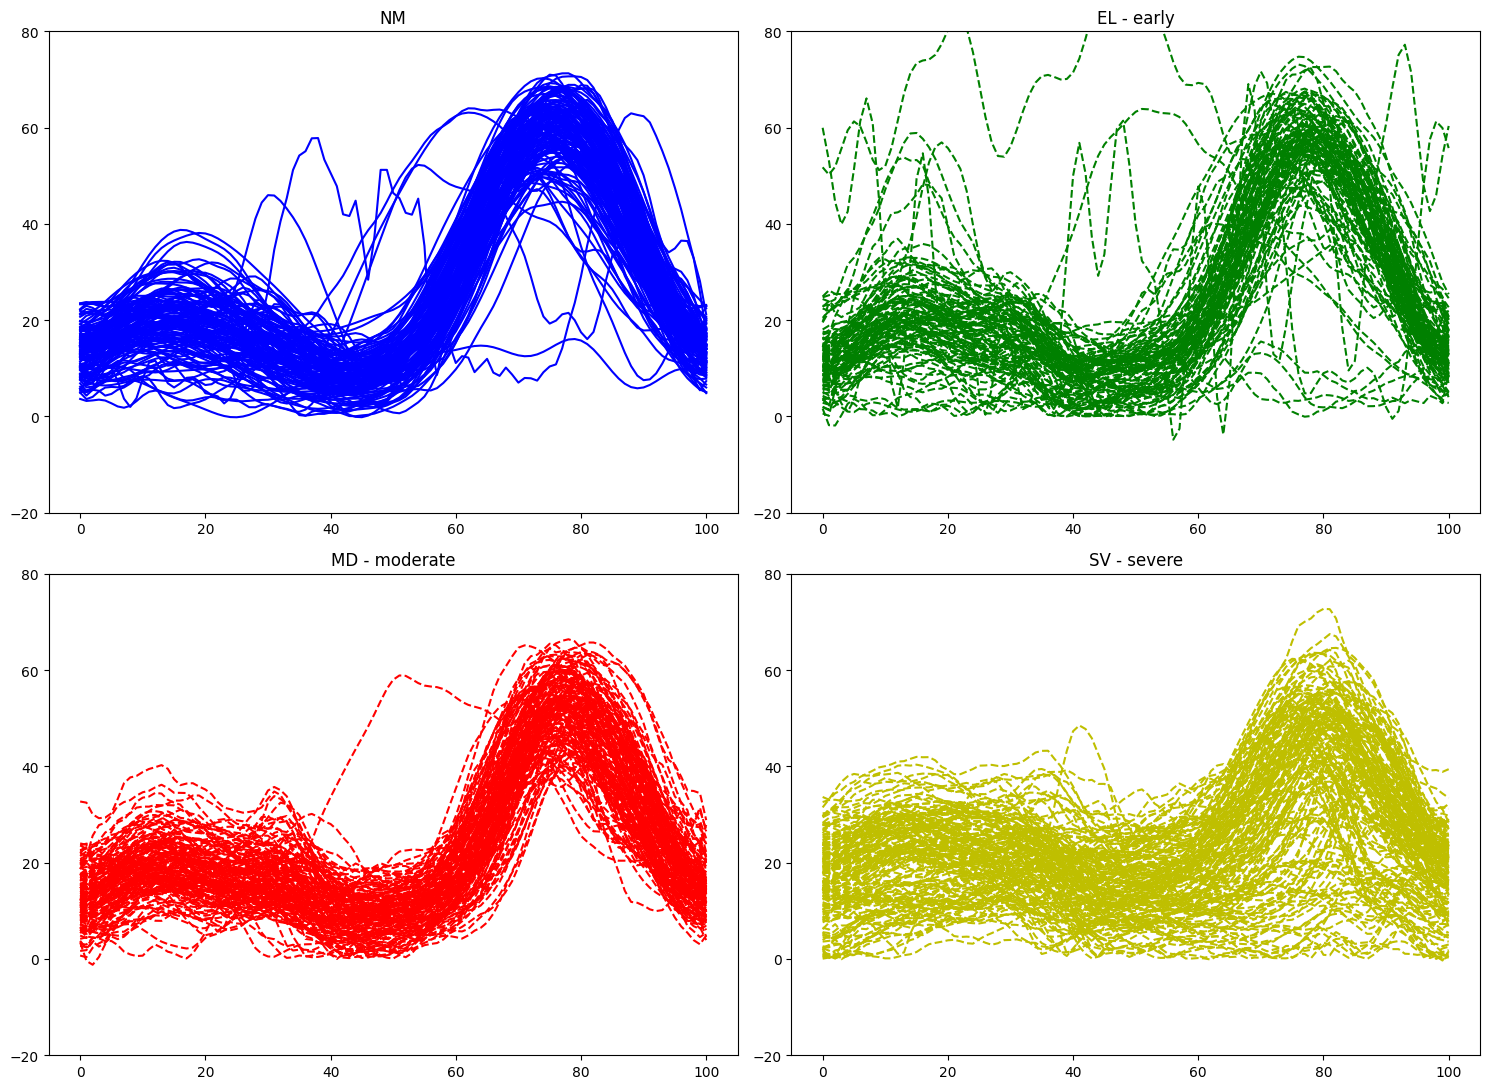

In [17]:
plot_this = 'r'
print(plot_this)
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 11))
ax = ax.flatten()

for _, d in gait_cycle_dataset[gait_cycle_dataset['leg_side']==plot_this].iterrows():
    if d['target_class'] == 'NM':
        c = "blue"
        ax[0].plot(signal.resample(d['data_k'], 101), c)

    elif d['target_class'] == 'EL':
        c = "g--"
        ax[1].plot(signal.resample(d['data_k'], 101), c)

    elif d['target_class'] == 'MD':
        c = "r--"
        ax[2].plot(signal.resample(d['data_k'], 101), c)
        
    elif d['target_class'] == 'SV':
        c = "y--"        
        ax[3].plot(signal.resample(d['data_k'], 101), c)

ax[0].set_title('NM')
ax[1].set_title('EL - early')
ax[2].set_title('MD - moderate')
ax[3].set_title('SV - severe')
for i in range(4):
    ax[i].set_ylim([-20, 80])
plt.tight_layout()
plt.show()

l


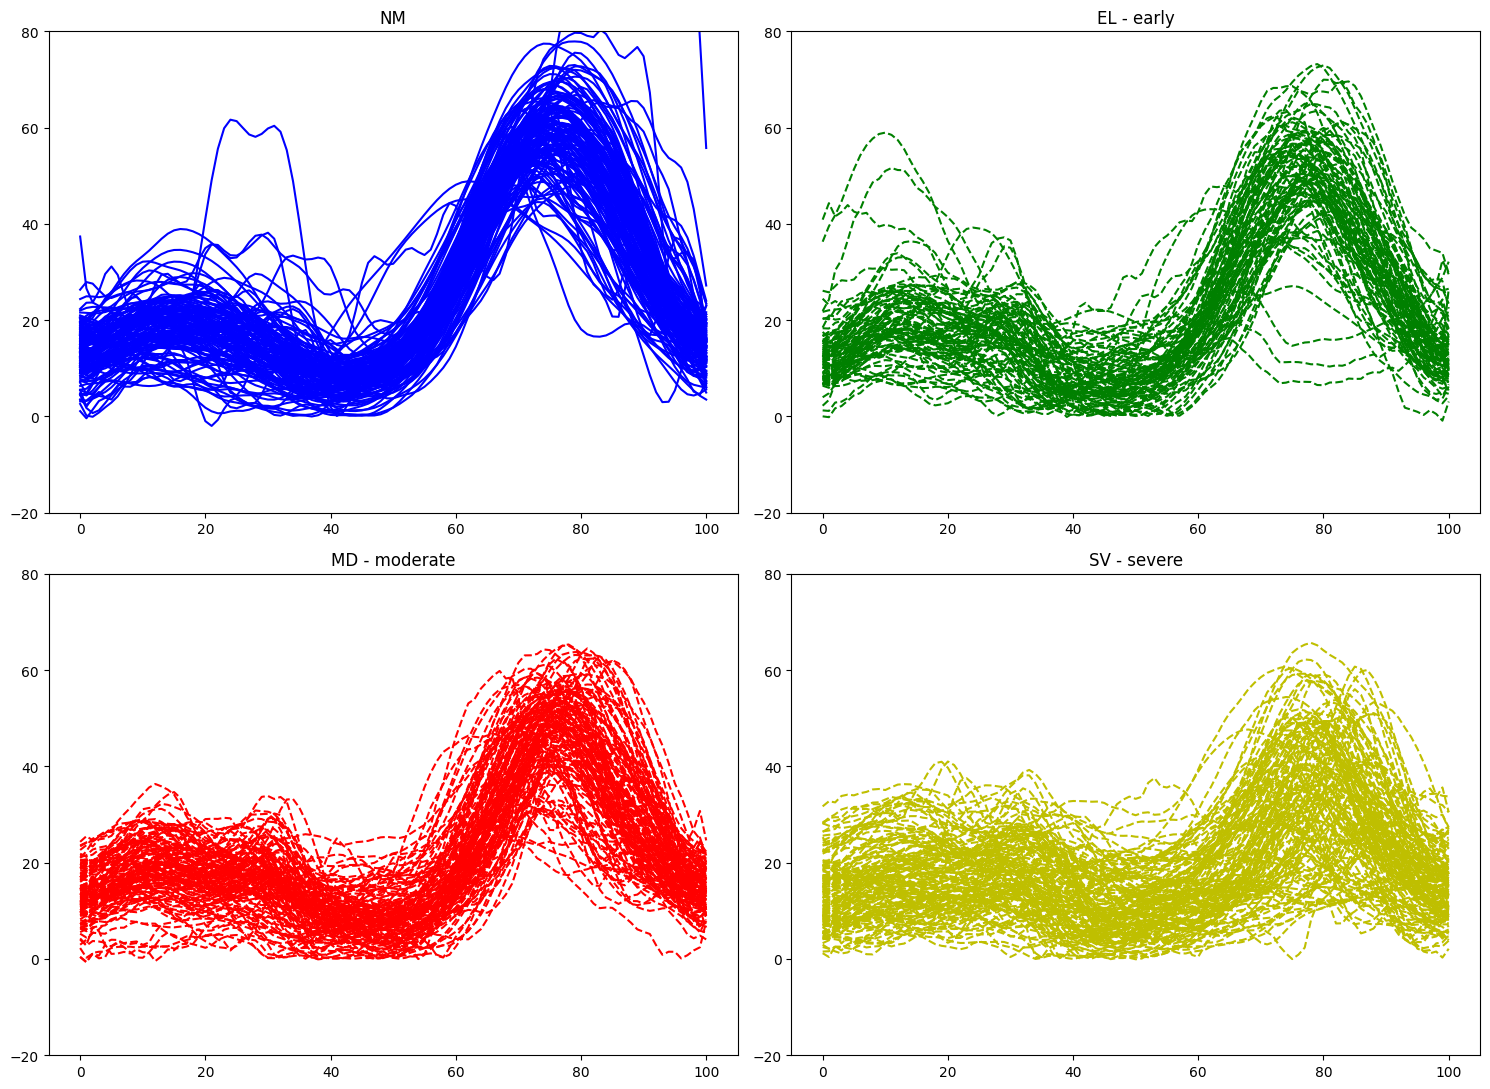

In [18]:
plot_this = 'l'
print(plot_this)
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 11))
ax = ax.flatten()

for _, d in gait_cycle_dataset[gait_cycle_dataset['leg_side']==plot_this].iterrows():
    if d['target_class'] == 'NM':
        c = "blue"
        ax[0].plot(signal.resample(d['data_k'], 101), c)

    elif d['target_class'] == 'EL':
        c = "g--"
        ax[1].plot(signal.resample(d['data_k'], 101), c)

    elif d['target_class'] == 'MD':
        c = "r--"
        ax[2].plot(signal.resample(d['data_k'], 101), c)
        
    elif d['target_class'] == 'SV':
        c = "y--"        
        ax[3].plot(signal.resample(d['data_k'], 101), c)

ax[0].set_title('NM')
ax[1].set_title('EL - early')
ax[2].set_title('MD - moderate')
ax[3].set_title('SV - severe')
for i in range(4):
    ax[i].set_ylim([-20, 80])
plt.tight_layout()
plt.show()

In [19]:
gait_cycle_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1033 entries, 0 to 1032
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   file              1033 non-null   object
 1   target_class      1033 non-null   object
 2   direction         1033 non-null   object
 3   leg_side          1033 non-null   object
 4   step_no           1033 non-null   object
 5   data_k            1033 non-null   object
 6   poses2d_filtered  1033 non-null   object
 7   poses3d_filtered  1033 non-null   object
dtypes: object(8)
memory usage: 64.7+ KB


In [20]:
gait_cycle_dataset['direction'].value_counts()

direction
left2right    521
right2left    512
Name: count, dtype: int64

Save data

In [ ]:
# import pickle

# # Saving the objects:
# with open('gait_cycle_dataset_knee.pkl', 'wb') as f:  
#     pickle.dump(gait_cycle_dataset, f)

# # Getting back the objects:
# with open('gait_cycle_dataset_knee_hip_all.pkl', 'rb') as f:  
#     gait_cycle_dataset1 = pickle.load(f)
# gait_cycle_dataset1.shape